In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import datetime
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# 1. Load and preprocess the data
def load_data(file_path):
    """
    Load data from CSV and perform initial preprocessing
    """
    print("Loading data from:", file_path)
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded dataset with shape: {df.shape}")
        print("\nFirst 5 rows of the dataset:")
        print(df.head())
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(df):
    """
    Preprocess the data by:
    - Handling missing values
    - Converting timestamp to datetime
    - Extracting time-based features
    """
    print("\n--- Starting data preprocessing ---")

    # Make a copy to avoid modifying the original
    df_processed = df.copy()

    # Check for missing values
    print("\nMissing values before handling:")
    print(df_processed.isnull().sum())

    # Fill missing values - specific handling for each column
    if 'Amount' in df_processed.columns:
        # For amounts, use the median (more robust to outliers than mean)
        df_processed['Amount'] = df_processed['Amount'].fillna(df_processed['Amount'].median())

    if 'Merchant' in df_processed.columns:
        # For categorical, use the most frequent value
        df_processed['Merchant'] = df_processed['Merchant'].fillna(df_processed['Merchant'].mode()[0])

    if 'TransactionType' in df_processed.columns:
        df_processed['TransactionType'] = df_processed['TransactionType'].fillna(df_processed['TransactionType'].mode()[0])

    if 'Location' in df_processed.columns:
        df_processed['Location'] = df_processed['Location'].fillna(df_processed['Location'].mode()[0])

    # Process the timestamp column - handle the format error you encountered
    if 'Timestamp' in df_processed.columns:
        print("\nHandling Timestamp column...")
        try:
            # First check the format of timestamps
            example_timestamp = df_processed['Timestamp'].iloc[0]
            print(f"Example timestamp: {example_timestamp}")

            # Try to parse with seconds
            try:
                df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'], format='%d-%m-%Y %H:%M:%S')
                print("Parsed timestamps with seconds format")
            except ValueError:
                # If fails, try without seconds
                try:
                    df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'], format='%d-%m-%Y %H:%M')
                    print("Parsed timestamps without seconds format")
                except ValueError:
                    # If still failing, use a more flexible approach
                    df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'], dayfirst=True)
                    print("Used flexible datetime parsing")

            # Extract useful time features
            df_processed['Hour'] = df_processed['Timestamp'].dt.hour
            df_processed['Day'] = df_processed['Timestamp'].dt.day
            df_processed['DayOfWeek'] = df_processed['Timestamp'].dt.dayofweek
            df_processed['Month'] = df_processed['Timestamp'].dt.month
            df_processed['Weekend'] = df_processed['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)  # 5 and 6 are weekend days

            # Add a feature for business hours (9 AM to 5 PM, Monday to Friday)
            df_processed['BusinessHours'] = ((df_processed['Hour'] >= 9) &
                                           (df_processed['Hour'] <= 17) &
                                           (df_processed['DayOfWeek'] < 5)).astype(int)

            print("Created time-based features: Hour, Day, DayOfWeek, Month, Weekend, BusinessHours")
        except Exception as e:
            print(f"Error processing timestamps: {e}")
            # If timestamp processing fails, create a dummy column to avoid breaking the pipeline
            df_processed['Hour'] = 0
            df_processed['Day'] = 0
            df_processed['DayOfWeek'] = 0
            df_processed['Month'] = 0
            df_processed['Weekend'] = 0
            df_processed['BusinessHours'] = 0

    # Ensure no missing values remain
    print("\nChecking for remaining missing values...")
    for column in df_processed.columns:
        if df_processed[column].isnull().sum() > 0:
            print(f"Filling remaining NA values in {column}")
            if df_processed[column].dtype == 'object':
                df_processed[column] = df_processed[column].fillna('Unknown')
            else:
                df_processed[column] = df_processed[column].fillna(0)

    print("\nMissing values after handling:")
    print(df_processed.isnull().sum())

    print("\nShape after preprocessing:", df_processed.shape)
    return df_processed

In [ ]:
# 2. Feature Engineering
def engineer_features(df):
    """
    Create additional features that might help detect fraud:
    - Transaction frequency metrics
    - Amount statistics by account
    - Behavioral patterns
    """
    print("\n--- Starting feature engineering ---")
    df_featured = df.copy()

    # Group transactions by account
    if 'AccountID' in df_featured.columns and 'Amount' in df_featured.columns:
        print("Creating account-based features...")

        # Transaction amount statistics per account
        account_stats = df_featured.groupby('AccountID')['Amount'].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
        account_stats.columns = ['AccountID', 'Avg_Amount', 'Std_Amount', 'Min_Amount', 'Max_Amount', 'Tx_Count']

        # Merge stats back to main dataframe
        df_featured = pd.merge(df_featured, account_stats, on='AccountID', how='left')

        # Calculate amount ratio (current amount / average amount for that account)
        # This helps identify transactions that are unusually large for a particular account
        df_featured['Amount_Ratio'] = df_featured['Amount'] / df_featured['Avg_Amount']

        # Replace infinity values (caused by division by zero) with a large number
        df_featured['Amount_Ratio'] = df_featured['Amount_Ratio'].replace([np.inf, -np.inf], 999)

        # Fill NaN values that might have been created
        df_featured['Amount_Ratio'] = df_featured['Amount_Ratio'].fillna(1)

        print("Created account-based features: Avg_Amount, Std_Amount, Min_Amount, Max_Amount, Tx_Count, Amount_Ratio")

    # Create time-window based features if timestamp is available
    if 'Timestamp' in df_featured.columns:
        print("Creating time-window based features...")

        # First check if Timestamp is already a datetime or needs conversion
        if not pd.api.types.is_datetime64_any_dtype(df_featured['Timestamp']):
            try:
                # Try to convert if it's not already datetime
                df_featured['Timestamp'] = pd.to_datetime(df_featured['Timestamp'], dayfirst=True)
                print("Converted Timestamp to datetime format")
            except Exception as e:
                print(f"Could not convert timestamps to datetime: {e}")
                print("Skipping time-window features that require datetime")
                return df_featured

        try:
            # Sort by timestamp - handle case where some timestamps might be missing
            df_featured = df_featured.copy()  # Avoid SettingWithCopyWarning
            df_featured.sort_values(['AccountID', 'Timestamp'], inplace=True)

            # Calculate time difference between consecutive transactions for the same account
            df_featured['Prev_Tx_Time'] = df_featured.groupby('AccountID')['Timestamp'].shift(1)

            # Convert to numeric hours, handling NaT values
            df_featured['Time_Since_Last_Tx'] = pd.to_numeric(
                (df_featured['Timestamp'] - df_featured['Prev_Tx_Time']).dt.total_seconds(),
                errors='coerce'
            ) / 3600  # convert seconds to hours

            # Fill NaN values (first transaction for each account or conversion errors)
            df_featured['Time_Since_Last_Tx'] = df_featured['Time_Since_Last_Tx'].fillna(24)  # assume 24 hours for first transaction

            # Flag rapid succession transactions safely
            # Convert to numeric type first to avoid comparison issues
            df_featured['Rapid_Succession'] = (df_featured['Time_Since_Last_Tx'] < 1).astype(int)  # less than 1 hour

            print("Created time-window features: Time_Since_Last_Tx, Rapid_Succession")
        except Exception as e:
            print(f"Error creating time-window features: {e}")
            print("Continuing without time-window features")
            # Create dummy columns to avoid breaking the pipeline
            df_featured['Time_Since_Last_Tx'] = 24  # default value
            df_featured['Rapid_Succession'] = 0     # default value

    # Create location-based features if available
    if 'Location' in df_featured.columns:
        print("Creating location-based features...")

        try:
            # Get most common location for each account - safer approach
            account_locations = df_featured.groupby('AccountID')['Location'].apply(
                lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else "Unknown"
            ).reset_index()
            account_locations.columns = ['AccountID', 'Common_Location']

            # Ensure no NaN/None values in the locations before comparison
            df_featured['Location'] = df_featured['Location'].fillna("Unknown")

            # Merge back to main dataframe
            df_featured = pd.merge(df_featured, account_locations, on='AccountID', how='left')

            # Handle any missing values from the merge
            df_featured['Common_Location'] = df_featured['Common_Location'].fillna(df_featured['Location'])

            # Flag transactions not in the common location for an account
            df_featured['Location_Change'] = (df_featured['Location'] != df_featured['Common_Location']).astype(int)

            print("Created location-based feature: Location_Change")
        except Exception as e:
            print(f"Error creating location-based features: {e}")
            print("Continuing without location-based features")
            # Create dummy column to avoid breaking the pipeline
            df_featured['Location_Change'] = 0  # default value

    # Handle categorical variables - we'll do one-hot encoding later in the pipeline

    print("\nFeature engineering completed. New dataframe shape:", df_featured.shape)
    print("\nNew features created:")
    new_features = set(df_featured.columns) - set(df.columns)
    print(list(new_features))

    return df_featured


In [ ]:
# 3. Split the dataset into train, test, and validation sets
def split_data(df, target_col=None):
    """
    Split the data into training, validation, and test sets
    For unsupervised learning, we don't have a target but we still split to evaluate performance
    """
    print("\n--- Splitting dataset ---")

    try:
        # Reset index to avoid any issues with duplicated indices
        df = df.reset_index(drop=True)

        # Make a copy to avoid SettingWithCopyWarning
        df_copy = df.copy()

        # First split into training (70%) and temp (30%)
        train_df, temp_df = train_test_split(df_copy, test_size=0.3, random_state=42)

        # Then split temp into validation (10% of original) and test (20% of original)
        # This is 1/3 and 2/3 of temp respectively
        val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42)

        print(f"Training set: {train_df.shape[0]} records ({train_df.shape[0]/df.shape[0]*100:.1f}%)")
        print(f"Validation set: {val_df.shape[0]} records ({val_df.shape[0]/df.shape[0]*100:.1f}%)")
        print(f"Test set: {test_df.shape[0]} records ({test_df.shape[0]/df.shape[0]*100:.1f}%)")

        # Reset indices again to avoid any potential issues
        train_df = train_df.reset_index(drop=True)
        val_df = val_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)

        return train_df, val_df, test_df

    except Exception as e:
        print(f"Error splitting data: {e}")
        print("Using simplified split approach")

        # If the above fails, use a simpler approach
        total_rows = len(df)
        train_idx = int(total_rows * 0.7)
        val_idx = int(total_rows * 0.8)

        train_df = df.iloc[:train_idx].copy().reset_index(drop=True)
        val_df = df.iloc[train_idx:val_idx].copy().reset_index(drop=True)
        test_df = df.iloc[val_idx:].copy().reset_index(drop=True)

        print(f"Training set: {len(train_df)} records")
        print(f"Validation set: {len(val_df)} records")
        print(f"Test set: {len(test_df)} records")

        return train_df, val_df, test_df


In [ ]:
# 4. Create the anomaly detection models
def prepare_features(df, categorical_cols, numerical_cols):
    """
    Prepare features for modeling by:
    - One-hot encoding categorical features
    - Scaling numerical features
    """
    print("\n--- Preparing features for modeling ---")

    # Filter out categorical columns that don't exist in the dataframe
    valid_categorical_cols = [col for col in categorical_cols if col in df.columns]
    valid_numerical_cols = [col for col in numerical_cols if col in df.columns]

    print(f"Valid categorical columns: {valid_categorical_cols}")
    print(f"Valid numerical columns: {valid_numerical_cols}")

    # Handle empty lists
    if not valid_numerical_cols:
        print("Warning: No valid numerical columns found. Adding placeholder.")
        df['numerical_placeholder'] = 0
        valid_numerical_cols = ['numerical_placeholder']

    transformers = []

    # Add numerical transformer
    transformers.append(('num', StandardScaler(), valid_numerical_cols))

    # Add categorical transformer only if we have valid categorical columns
    if valid_categorical_cols:
        # Create a safer one-hot encoder
        transformers.append((
            'cat',
            OneHotEncoder(
                handle_unknown='ignore',
                sparse_output=False,
                drop=None
            ),
            valid_categorical_cols
        ))

    # Create a preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'  # Drop any columns not specified
    )

    print(f"Preprocessing {len(valid_numerical_cols)} numerical features and {len(valid_categorical_cols)} categorical features")

    return preprocessor

def build_models():
    """
    Build the anomaly detection models:
    - Isolation Forest
    - Local Outlier Factor
    """
    print("\n--- Building models ---")

    # Isolation Forest model
    iso_forest = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=0.05,  # assume about 5% of transactions are fraudulent
        random_state=42
    )

    # Local Outlier Factor model
    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=0.05,
        novelty=True  # required for prediction on new data
    )

    print("Created Isolation Forest and Local Outlier Factor models")

    return iso_forest, lof


In [ ]:
# 5. Train and evaluate the models
def train_and_evaluate_models(train_df, val_df, preprocessor, numerical_cols, categorical_cols):
    """
    Train the models and evaluate them on the validation set
    """
    print("\n--- Training and evaluating models ---")

    # Get the feature columns (excluding any target columns)
    # Only include columns that actually exist in both DataFrames
    valid_numerical_cols = [col for col in numerical_cols if col in train_df.columns and col in val_df.columns]
    valid_categorical_cols = [col for col in categorical_cols if col in train_df.columns and col in val_df.columns]

    feature_cols = valid_numerical_cols + valid_categorical_cols
    print(f"Using {len(feature_cols)} features for training: {feature_cols}")

    # Safety check - need at least one feature
    if len(feature_cols) == 0:
        print("Warning: No valid features found. Adding Amount as default feature.")
        if 'Amount' in train_df.columns and 'Amount' in val_df.columns:
            feature_cols = ['Amount']
        else:
            # Create a dummy feature if even Amount is not available
            train_df['dummy_feature'] = 1.0
            val_df['dummy_feature'] = 1.0
            feature_cols = ['dummy_feature']

    # Make sure there are no missing values in feature columns
    for col in feature_cols:
        if train_df[col].isnull().any() or val_df[col].isnull().any():
            print(f"Filling missing values in feature column: {col}")
            if train_df[col].dtype == 'object':
                # For categorical columns
                train_df[col] = train_df[col].fillna('Unknown')
                val_df[col] = val_df[col].fillna('Unknown')
            else:
                # For numerical columns
                train_df[col] = train_df[col].fillna(train_df[col].median() if len(train_df[col].dropna()) > 0 else 0)
                val_df[col] = val_df[col].fillna(val_df[col].median() if len(val_df[col].dropna()) > 0 else 0)

    # Extract features
    X_train = train_df[feature_cols].copy()
    X_val = val_df[feature_cols].copy()

    # Apply preprocessing
    print("Applying preprocessing transformations...")
    try:
        # Create a safer preprocessor if needed
        if preprocessor is None:
            print("Creating a new preprocessor")
            transformers = []
            if valid_numerical_cols:
                transformers.append(('num', StandardScaler(), valid_numerical_cols))
            if valid_categorical_cols:
                transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), valid_categorical_cols))

            if transformers:
                preprocessor = ColumnTransformer(transformers=transformers)
            else:
                # If no valid transformers, just pass through the data
                from sklearn.preprocessing import FunctionTransformer
                preprocessor = FunctionTransformer(lambda X: X)

        # Fit and transform
        preprocessor.fit(X_train)
        X_train_processed = preprocessor.transform(X_train)
        X_val_processed = preprocessor.transform(X_val)

        print(f"Processed training data shape: {X_train_processed.shape}")

        # Check for NaN or inf values after preprocessing
        if np.isnan(X_train_processed).any() or np.isinf(X_train_processed).any():
            print("Warning: NaN or inf values found after preprocessing. Fixing...")
            X_train_processed = np.nan_to_num(X_train_processed)

        if np.isnan(X_val_processed).any() or np.isinf(X_val_processed).any():
            print("Warning: NaN or inf values found after preprocessing. Fixing...")
            X_val_processed = np.nan_to_num(X_val_processed)

    except Exception as e:
        print(f"Error in preprocessing: {e}")
        # Fallback: just use numerical features if preprocessing fails
        print("Falling back to simple preprocessing")

        # Just use Amount column or create a dummy feature
        if 'Amount' in train_df.columns and 'Amount' in val_df.columns:
            print("Using Amount feature only")
            X_train_processed = train_df[['Amount']].values
            X_val_processed = val_df[['Amount']].values
        else:
            print("Creating dummy feature")
            X_train_processed = np.ones((len(train_df), 1))
            X_val_processed = np.ones((len(val_df), 1))

    # Build the models
    try:
        iso_forest, lof = build_models()

        # Train Isolation Forest
        print("\nTraining Isolation Forest model...")
        iso_forest.fit(X_train_processed)

        # Train LOF
        print("Training Local Outlier Factor model...")
        lof.fit(X_train_processed)

        # Score the validation set
        print("\nScoring validation data...")

        # Isolation Forest predictions
        iso_forest_scores = iso_forest.decision_function(X_val_processed)
        iso_forest_predictions = iso_forest.predict(X_val_processed)
        # Convert to binary labels (1 for normal, -1 for anomalies)
        iso_forest_predictions = [1 if x == 1 else -1 for x in iso_forest_predictions]

        # LOF predictions
        lof_scores = lof.decision_function(X_val_processed)
        lof_predictions = lof.predict(X_val_processed)
        # LOF already gives -1 for anomalies and 1 for normal

    except Exception as e:
        print(f"Error in model training or scoring: {e}")
        print("Using random predictions as fallback")

        # Create random scores and predictions as fallback
        np.random.seed(42)  # For reproducibility
        iso_forest_scores = np.random.normal(0, 1, size=len(val_df))
        lof_scores = np.random.normal(0, 1, size=len(val_df))

        # Generate predictions with approximately 5% anomalies
        iso_forest_predictions = [1 if x > -1.6 else -1 for x in iso_forest_scores]  # ~5% will be -1
        lof_predictions = [1 if x > -1.6 else -1 for x in lof_scores]  # ~5% will be -1

        # Create dummy models
        from sklearn.base import BaseEstimator
        class DummyModel(BaseEstimator):
            def fit(self, X, y=None):
                return self
            def predict(self, X):
                return np.ones(len(X))
            def decision_function(self, X):
                return np.zeros(len(X))

        iso_forest = DummyModel()
        lof = DummyModel()

    # Add predictions to validation data
    val_results = val_df.copy()
    val_results['IsoForest_Score'] = iso_forest_scores
    val_results['IsoForest_Prediction'] = iso_forest_predictions
    val_results['LOF_Score'] = lof_scores
    val_results['LOF_Prediction'] = lof_predictions

    # Create ensemble prediction (anomaly if either model predicts it)
    val_results['Ensemble_Prediction'] = np.where(
        (val_results['IsoForest_Prediction'] == -1) | (val_results['LOF_Prediction'] == -1),
        -1, 1
    )

    print("\nValidation results summary:")
    print(f"Isolation Forest anomalies: {(val_results['IsoForest_Prediction'] == -1).sum()} ({(val_results['IsoForest_Prediction'] == -1).sum() / len(val_results) * 100:.2f}%)")
    print(f"LOF anomalies: {(val_results['LOF_Prediction'] == -1).sum()} ({(val_results['LOF_Prediction'] == -1).sum() / len(val_results) * 100:.2f}%)")
    print(f"Ensemble anomalies: {(val_results['Ensemble_Prediction'] == -1).sum()} ({(val_results['Ensemble_Prediction'] == -1).sum() / len(val_results) * 100:.2f}%)")

    return iso_forest, lof, preprocessor, val_results


In [ ]:
# 7. Test the model on the test set
def test_model(test_df, iso_forest, lof, preprocessor, numerical_cols, categorical_cols, iso_threshold, lof_threshold):
    """
    Test the model on the unseen test data
    """
    print("\n--- Testing models on test data ---")

    # Extract features
    feature_cols = numerical_cols + categorical_cols
    X_test = test_df[feature_cols]

    # Preprocess
    try:
        X_test_processed = preprocessor.transform(X_test)
    except Exception as e:
        print(f"Error in preprocessing test data: {e}")
        # Fallback
        X_test_processed = test_df[numerical_cols].values

    # Make predictions
    iso_forest_scores = iso_forest.decision_function(X_test_processed)
    lof_scores = lof.decision_function(X_test_processed)

    # Apply custom thresholds
    iso_forest_predictions = np.where(iso_forest_scores <= iso_threshold, -1, 1)
    lof_predictions = np.where(lof_scores <= lof_threshold, -1, 1)

    # Add to test results
    test_results = test_df.copy()
    test_results['IsoForest_Score'] = iso_forest_scores
    test_results['IsoForest_Prediction'] = iso_forest_predictions
    test_results['LOF_Score'] = lof_scores
    test_results['LOF_Prediction'] = lof_predictions

    # Ensemble prediction
    test_results['Ensemble_Prediction'] = np.where(
        (test_results['IsoForest_Prediction'] == -1) | (test_results['LOF_Prediction'] == -1),
        -1, 1
    )

    print("\nTest results summary:")
    print(f"Isolation Forest anomalies: {(test_results['IsoForest_Prediction'] == -1).sum()} ({(test_results['IsoForest_Prediction'] == -1).sum() / len(test_results) * 100:.2f}%)")
    print(f"LOF anomalies: {(test_results['LOF_Prediction'] == -1).sum()} ({(test_results['LOF_Prediction'] == -1).sum() / len(test_results) * 100:.2f}%)")
    print(f"Ensemble anomalies: {(test_results['Ensemble_Prediction'] == -1).sum()} ({(test_results['Ensemble_Prediction'] == -1).sum() / len(test_results) * 100:.2f}%)")

    return test_results


In [ ]:
# Add this function after test_model() to save fraud transactions to separate files
def save_fraud_transactions(test_results, output_folder='fraud_results'):
    """
    Save fraudulent transactions detected by each model to separate CSV files,
    ordered by anomaly score from most to least anomalous.

    Parameters:
    -----------
    test_results : pandas.DataFrame
        DataFrame containing the test results with predictions
    output_folder : str
        Folder to save the output files
    """
    import os
    import pandas as pd

    print(f"\n--- Saving fraudulent transactions to {output_folder} folder ---")

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Isolation Forest frauds
    iso_frauds = test_results[test_results['IsoForest_Prediction'] == -1].copy()
    if len(iso_frauds) > 0:
        # Sort by score (ascending) - lower scores are more anomalous for Isolation Forest
        iso_frauds = iso_frauds.sort_values('IsoForest_Score')
        iso_frauds.to_csv(f"{output_folder}/isolation_forest_frauds.csv", index=False)
        print(f"Saved {len(iso_frauds)} Isolation Forest frauds to {output_folder}/isolation_forest_frauds.csv")
    else:
        print("No frauds detected by Isolation Forest")

    # LOF frauds
    lof_frauds = test_results[test_results['LOF_Prediction'] == -1].copy()
    if len(lof_frauds) > 0:
        # Sort by score (ascending) - lower scores are more anomalous for LOF
        lof_frauds = lof_frauds.sort_values('LOF_Score')
        lof_frauds.to_csv(f"{output_folder}/lof_frauds.csv", index=False)
        print(f"Saved {len(lof_frauds)} LOF frauds to {output_folder}/lof_frauds.csv")
    else:
        print("No frauds detected by LOF")

    # Ensemble frauds (detected by either model)
    ensemble_frauds = test_results[test_results['Ensemble_Prediction'] == -1].copy()
    if len(ensemble_frauds) > 0:
        # Create a combined score (sum of normalized scores)
        min_iso = test_results['IsoForest_Score'].min()
        max_iso = test_results['IsoForest_Score'].max()
        min_lof = test_results['LOF_Score'].min()
        max_lof = test_results['LOF_Score'].max()

        # Handle edge cases to avoid division by zero
        iso_range = max_iso - min_iso
        lof_range = max_lof - min_lof

        if iso_range > 0:
            ensemble_frauds['IsoForest_Score_Norm'] = (ensemble_frauds['IsoForest_Score'] - min_iso) / iso_range
        else:
            ensemble_frauds['IsoForest_Score_Norm'] = 0

        if lof_range > 0:
            ensemble_frauds['LOF_Score_Norm'] = (ensemble_frauds['LOF_Score'] - min_lof) / lof_range
        else:
            ensemble_frauds['LOF_Score_Norm'] = 0

        # Combined score (lower is more anomalous)
        ensemble_frauds['Combined_Score'] = ensemble_frauds['IsoForest_Score_Norm'] + ensemble_frauds['LOF_Score_Norm']

        # Sort by combined score (ascending)
        ensemble_frauds = ensemble_frauds.sort_values('Combined_Score')
        ensemble_frauds.to_csv(f"{output_folder}/ensemble_frauds.csv", index=False)
        print(f"Saved {len(ensemble_frauds)} Ensemble frauds to {output_folder}/ensemble_frauds.csv")
    else:
        print("No frauds detected by the Ensemble method")

    return {
        'iso_forest': len(iso_frauds) if 'iso_frauds' in locals() else 0,
        'lof': len(lof_frauds) if 'lof_frauds' in locals() else 0,
        'ensemble': len(ensemble_frauds) if 'ensemble_frauds' in locals() else 0
    }



new

In [ ]:
# This is the corrected version of the scatter plot section in analyze_anomaly_score_distribution
def analyze_anomaly_score_distribution(test_results, output_folder='fraud_results'):
    """
    Analyze the distribution of anomaly scores for Isolation Forest and LOF
    using a fixed 5% contamination rate.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    print(f"\n--- Analyzing anomaly score distribution with fixed 5% contamination rate ---")

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get scores
    iso_scores = test_results['IsoForest_Score'].values
    lof_scores = test_results['LOF_Score'].values

    # Calculate 5% thresholds
    iso_threshold = np.percentile(iso_scores, 5)
    lof_threshold = np.percentile(lof_scores, 5)

    print(f"Using fixed 5% contamination rate:")
    print(f"Isolation Forest threshold: {iso_threshold:.6f}")
    print(f"LOF threshold: {lof_threshold:.6f}")

    # Count anomalies at 5% threshold
    iso_anomalies = (iso_scores <= iso_threshold).sum()
    lof_anomalies = (lof_scores <= lof_threshold).sum()
    ensemble_anomalies = ((iso_scores <= iso_threshold) | (lof_scores <= lof_threshold)).sum()

    print(f"Isolation Forest anomalies: {iso_anomalies} ({iso_anomalies/len(test_results)*100:.2f}%)")
    print(f"LOF anomalies: {lof_anomalies} ({lof_anomalies/len(test_results)*100:.2f}%)")
    print(f"Ensemble anomalies: {ensemble_anomalies} ({ensemble_anomalies/len(test_results)*100:.2f}%)")

    # Create figure for distributions
    plt.figure(figsize=(15, 10))

    # Isolation Forest scores distribution
    plt.subplot(2, 2, 1)
    sns.histplot(iso_scores, bins=50, kde=True)
    plt.axvline(x=iso_threshold, color='r', linestyle='--',
                label='5% Threshold')
    plt.title('Isolation Forest Anomaly Score Distribution')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # LOF scores distribution
    plt.subplot(2, 2, 2)
    sns.histplot(lof_scores, bins=50, kde=True)
    plt.axvline(x=lof_threshold, color='r', linestyle='--',
                label='5% Threshold')
    plt.title('LOF Anomaly Score Distribution')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Scatter plot of Isolation Forest vs LOF scores
    plt.subplot(2, 2, 3)

    # FIX: Use a list instead of numpy array for colors to avoid truncation
    colors = ['blue'] * len(test_results)
    for i in range(len(colors)):
        if iso_scores[i] <= iso_threshold and lof_scores[i] > lof_threshold:
            colors[i] = 'green'  # ISO only
        elif iso_scores[i] > iso_threshold and lof_scores[i] <= lof_threshold:
            colors[i] = 'orange'  # LOF only
        elif iso_scores[i] <= iso_threshold and lof_scores[i] <= lof_threshold:
            colors[i] = 'red'     # Both

    plt.scatter(iso_scores, lof_scores, c=colors, alpha=0.6)
    plt.axvline(x=iso_threshold, color='r', linestyle='--',
                label='ISO 5% Threshold')
    plt.axhline(y=lof_threshold, color='g', linestyle='--',
                label='LOF 5% Threshold')
    plt.title('Isolation Forest vs LOF Scores')
    plt.xlabel('Isolation Forest Score')
    plt.ylabel('LOF Score')

    # Add a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='ISO Forest Only'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='LOF Only'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Both Models'),
        Line2D([0], [0], color='r', linestyle='--', label='ISO 5% Threshold'),
        Line2D([0], [0], color='g', linestyle='--', label='LOF 5% Threshold')
    ]
    plt.legend(handles=legend_elements)
    plt.grid(True, alpha=0.3)

    # Model agreement analysis
    plt.subplot(2, 2, 4)

    # Calculate statistics on model agreement
    both_count = ((iso_scores <= iso_threshold) & (lof_scores <= lof_threshold)).sum()
    iso_only = ((iso_scores <= iso_threshold) & (lof_scores > lof_threshold)).sum()
    lof_only = ((iso_scores > iso_threshold) & (lof_scores <= lof_threshold)).sum()
    agreement_pct = both_count / (both_count + iso_only + lof_only) * 100 if (both_count + iso_only + lof_only) > 0 else 0

    # Create a bar chart for model agreement
    labels = ['Both Models', 'ISO Forest Only', 'LOF Only']
    values = [both_count, iso_only, lof_only]
    colors = ['red', 'green', 'orange']

    plt.bar(labels, values, color=colors)
    plt.title(f'Model Agreement (5% contamination)\nOverlap: {agreement_pct:.1f}%')
    plt.ylabel('Number of Anomalies')

    # Add count labels on top of each bar
    for i, v in enumerate(values):
        plt.text(i, v + 0.5, str(v), ha='center')

    plt.tight_layout()
    plt.savefig(f"{output_folder}/anomaly_score_distribution.png")
    print(f"Saved anomaly score distribution visualization to {output_folder}/anomaly_score_distribution.png")

    return {
        'iso_threshold': iso_threshold,
        'lof_threshold': lof_threshold,
        'iso_anomalies': iso_anomalies,
        'lof_anomalies': lof_anomalies,
        'ensemble_anomalies': ensemble_anomalies,
        'agreement_percentage': agreement_pct
    }

new


In [ ]:
def analyze_feature_importance(test_results, test_df, numerical_cols, categorical_cols, output_folder='fraud_results'):
    """
    Analyze feature importance for anomaly detection models using:
    1. Permutation importance
    2. Feature distribution comparison between normal and anomalous transactions
    3. Correlation between features and anomaly scores

    Parameters:
    -----------
    test_results : pandas.DataFrame
        DataFrame containing the test results with predictions
    test_df : pandas.DataFrame
        Original test data with all features
    numerical_cols : list
        List of numerical feature columns
    categorical_cols : list
        List of categorical feature columns
    output_folder : str
        Folder to save output visualizations
    """
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler

    print("\n--- Analyzing Feature Importance ---")

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Combine test_results with original features
    analysis_df = test_results.copy()

    # Define anomalies based on ensemble prediction
    analysis_df['is_anomaly'] = analysis_df['Ensemble_Prediction'] == -1

    # 1. Correlation between features and anomaly scores
    print("\nAnalyzing correlation between features and anomaly scores...")

    # Create correlation dataframe for numerical features
    correlation_data = []

    for col in numerical_cols:
        if col in test_df.columns:
            iso_corr = np.corrcoef(test_df[col], -test_results['IsoForest_Score'])[0, 1]
            lof_corr = np.corrcoef(test_df[col], -test_results['LOF_Score'])[0, 1]
            correlation_data.append({
                'Feature': col,
                'Isolation_Forest_Correlation': iso_corr,
                'LOF_Correlation': lof_corr,
                'Average_Correlation': (abs(iso_corr) + abs(lof_corr)) / 2
            })

    corr_df = pd.DataFrame(correlation_data)
    if not corr_df.empty:
        corr_df = corr_df.sort_values('Average_Correlation', ascending=False)

        # Plot correlation heatmap
        plt.figure(figsize=(12, len(numerical_cols) * 0.5 + 2))
        corr_matrix = corr_df.set_index('Feature')[['Isolation_Forest_Correlation', 'LOF_Correlation']]
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Feature Correlation with Anomaly Scores')
        plt.tight_layout()
        plt.savefig(f"{output_folder}/feature_correlation.png")
        print(f"Saved feature correlation visualization to {output_folder}/feature_correlation.png")

        print("\nTop features by correlation with anomaly scores:")
        print(corr_df[['Feature', 'Average_Correlation']].head(10).to_string(index=False))

    # 2. Feature distribution comparison between normal and anomalous transactions
    print("\nComparing feature distributions between normal and anomalous transactions...")

    # Create directory for feature distribution plots
    feature_dist_folder = f"{output_folder}/feature_distributions"
    os.makedirs(feature_dist_folder, exist_ok=True)

    # Calculate feature importance based on distribution difference
    feature_importance = []

    # Function to calculate distribution difference (KS statistic)
    from scipy import stats

    def calc_distribution_diff(normal_values, anomaly_values):
        if len(normal_values) == 0 or len(anomaly_values) == 0:
            return 0

        try:
            ks_stat, _ = stats.ks_2samp(normal_values, anomaly_values)
            return ks_stat
        except:
            return 0

    # Analyze numerical features
    for col in numerical_cols:
        if col in test_df.columns:
            # Get values for normal and anomalous transactions
            normal_values = test_df[col][~analysis_df['is_anomaly']].values
            anomaly_values = test_df[col][analysis_df['is_anomaly']].values

            # Calculate distribution difference
            dist_diff = calc_distribution_diff(normal_values, anomaly_values)

            feature_importance.append({
                'Feature': col,
                'Distribution_Difference': dist_diff,
                'Type': 'Numerical'
            })

            # Create distribution plot
            plt.figure(figsize=(10, 6))
            sns.histplot(normal_values, color='blue', alpha=0.5, label='Normal', kde=True)
            sns.histplot(anomaly_values, color='red', alpha=0.5, label='Anomaly', kde=True)
            plt.title(f'Distribution of {col} (KS Diff: {dist_diff:.4f})')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"{feature_dist_folder}/{col}_distribution.png")
            plt.close()

    # Analyze categorical features
    for col in categorical_cols:
        if col in test_df.columns:
            # Create frequency distributions
            normal_freq = test_df[col][~analysis_df['is_anomaly']].value_counts(normalize=True)
            anomaly_freq = test_df[col][analysis_df['is_anomaly']].value_counts(normalize=True)

            # Combine and fill missing values with 0
            all_categories = set(normal_freq.index) | set(anomaly_freq.index)
            for cat in all_categories:
                if cat not in normal_freq:
                    normal_freq[cat] = 0
                if cat not in anomaly_freq:
                    anomaly_freq[cat] = 0

            # Calculate distribution difference (sum of absolute differences)
            common_categories = set(normal_freq.index) & set(anomaly_freq.index)
            dist_diff = sum(abs(normal_freq.get(cat, 0) - anomaly_freq.get(cat, 0)) for cat in common_categories) / 2

            feature_importance.append({
                'Feature': col,
                'Distribution_Difference': dist_diff,
                'Type': 'Categorical'
            })

            # Create bar plot for top categories (limit to top 10 for readability)
            top_categories = list((set(normal_freq.nlargest(5).index) |
                                  set(anomaly_freq.nlargest(5).index)))[:10]

            plot_data = pd.DataFrame({
                'Category': top_categories,
                'Normal': [normal_freq.get(cat, 0) for cat in top_categories],
                'Anomaly': [anomaly_freq.get(cat, 0) for cat in top_categories]
            })

            plt.figure(figsize=(12, 6))
            plot_data.set_index('Category').plot(kind='bar', alpha=0.7)
            plt.title(f'Distribution of {col} (Diff: {dist_diff:.4f})')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"{feature_dist_folder}/{col}_distribution.png")
            plt.close()

    # Combine and rank features by importance
    feat_imp_df = pd.DataFrame(feature_importance)
    if not feat_imp_df.empty:
        feat_imp_df = feat_imp_df.sort_values('Distribution_Difference', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(12, len(feat_imp_df) * 0.4 + 2))
        sns.barplot(x='Distribution_Difference', y='Feature', hue='Type', data=feat_imp_df)
        plt.title('Feature Importance Based on Distribution Difference')
        plt.tight_layout()
        plt.savefig(f"{output_folder}/feature_importance.png")
        print(f"Saved feature importance visualization to {output_folder}/feature_importance.png")

        print("\nFeatures ranked by importance (distribution difference):")
        print(feat_imp_df[['Feature', 'Distribution_Difference', 'Type']].head(10).to_string(index=False))

    return {
        'correlation': corr_df if 'corr_df' in locals() else None,
        'importance': feat_imp_df if 'feat_imp_df' in locals() else None,
    }

def analyze_anomaly_profiles(test_results, test_df, numerical_cols, categorical_cols, output_folder='fraud_results'):
    """
    Create profiles of anomalous transactions to understand patterns.

    Parameters:
    -----------
    test_results : pandas.DataFrame
        DataFrame containing the test results with predictions
    test_df : pandas.DataFrame
        Original test data with all features
    numerical_cols : list
        List of numerical feature columns
    categorical_cols : list
        List of categorical feature columns
    output_folder : str
        Folder to save output visualizations
    """
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    print("\n--- Creating Anomaly Profiles ---")

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Combine test results with original features
    analysis_df = test_df.copy()
    for col in ['IsoForest_Score', 'IsoForest_Prediction', 'LOF_Score',
                'LOF_Prediction', 'Ensemble_Prediction']:
        if col in test_results.columns:
            analysis_df[col] = test_results[col].values

    # Define anomalies based on ensemble prediction
    analysis_df['is_anomaly'] = analysis_df['Ensemble_Prediction'] == -1

    # 1. Profile of most anomalous transactions
    print("\nProfiling most anomalous transactions...")

    # Sort by anomaly scores to get top anomalies
    iso_anomalies = analysis_df[analysis_df['IsoForest_Prediction'] == -1].sort_values('IsoForest_Score')
    lof_anomalies = analysis_df[analysis_df['LOF_Prediction'] == -1].sort_values('LOF_Score')

    # Create summary statistics for numerical features
    num_stats = []
    for col in numerical_cols:
        if col in analysis_df.columns:
            normal_mean = analysis_df[col][~analysis_df['is_anomaly']].mean()
            normal_std = analysis_df[col][~analysis_df['is_anomaly']].std()
            anomaly_mean = analysis_df[col][analysis_df['is_anomaly']].mean()
            anomaly_std = analysis_df[col][analysis_df['is_anomaly']].std()

            if normal_std > 0:
                # Calculate standardized difference
                std_diff = (anomaly_mean - normal_mean) / normal_std
            else:
                std_diff = 0

            num_stats.append({
                'Feature': col,
                'Normal_Mean': normal_mean,
                'Anomaly_Mean': anomaly_mean,
                'Difference': anomaly_mean - normal_mean,
                'Std_Difference': std_diff,
                'Anomaly_Std': anomaly_std
            })

    num_stats_df = pd.DataFrame(num_stats)
    if not num_stats_df.empty:
        num_stats_df = num_stats_df.sort_values('Std_Difference', key=abs, ascending=False)

        # Plot most distinctive numerical features
        plt.figure(figsize=(12, 8))
        top_features = num_stats_df.head(10)['Feature'].tolist()

        for i, feature in enumerate(top_features):
            diff = num_stats_df[num_stats_df['Feature'] == feature]['Std_Difference'].values[0]
            plt.barh(feature, diff, color='blue' if diff > 0 else 'red')

        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Top Distinctive Numerical Features in Anomalies\n(Standardized Difference)')
        plt.xlabel('Standard Deviations from Normal Mean')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{output_folder}/anomaly_numerical_profile.png")
        print(f"Saved anomaly numerical profile to {output_folder}/anomaly_numerical_profile.png")

        print("\nTop distinctive numerical features in anomalies:")
        print(num_stats_df[['Feature', 'Normal_Mean', 'Anomaly_Mean', 'Std_Difference']].head(10).to_string(index=False))

    # Create summary for categorical features
    cat_stats = []
    for col in categorical_cols:
        if col in analysis_df.columns:
            # Get most common value for normal and anomalous transactions
            try:
                normal_top = analysis_df[col][~analysis_df['is_anomaly']].value_counts(normalize=True)
                anomaly_top = analysis_df[col][analysis_df['is_anomaly']].value_counts(normalize=True)

                # Get top 3 categories for each
                normal_top3 = normal_top.head(3)
                anomaly_top3 = anomaly_top.head(3)

                # Calculate overall difference in distributions
                all_categories = set(normal_top.index) | set(anomaly_top.index)
                dist_diff = sum(abs(normal_top.get(cat, 0) - anomaly_top.get(cat, 0)) for cat in all_categories) / 2

                cat_stats.append({
                    'Feature': col,
                    'Normal_Top': ', '.join([f"{cat} ({freq:.1%})" for cat, freq in normal_top3.items()]),
                    'Anomaly_Top': ', '.join([f"{cat} ({freq:.1%})" for cat, freq in anomaly_top3.items()]),
                    'Distribution_Difference': dist_diff
                })
            except:
                pass

    cat_stats_df = pd.DataFrame(cat_stats)
    if not cat_stats_df.empty:
        cat_stats_df = cat_stats_df.sort_values('Distribution_Difference', ascending=False)

        print("\nTop distinctive categorical features in anomalies:")
        print(cat_stats_df[['Feature', 'Normal_Top', 'Anomaly_Top', 'Distribution_Difference']].head(5).to_string(index=False))

    return {
        'numerical_stats': num_stats_df if 'num_stats_df' in locals() else None,
        'categorical_stats': cat_stats_df if 'cat_stats_df' in locals() else None
    }

def evaluate_feature_subsets(train_df, val_df, numerical_cols, categorical_cols, output_folder='fraud_results'):
    """
    Evaluate model performance with different feature subsets to determine
    which features are most important for anomaly detection.

    Parameters:
    -----------
    train_df : pandas.DataFrame
        Training data
    val_df : pandas.DataFrame
        Validation data
    numerical_cols : list
        List of numerical feature columns
    categorical_cols : list
        List of categorical feature columns
    output_folder : str
        Folder to save output visualizations
    """
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.preprocessing import StandardScaler

    print("\n--- Evaluating Feature Subset Importance ---")

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Define feature groups to test
    feature_groups = [
        {'name': 'All Features', 'num': numerical_cols, 'cat': categorical_cols},
        {'name': 'Amount Only', 'num': ['Amount'], 'cat': []},
        {'name': 'Time Features', 'num': [col for col in ['Hour', 'Day', 'DayOfWeek', 'Month', 'Time_Since_Last_Tx']
                                         if col in numerical_cols], 'cat': []},
        {'name': 'Account Stats', 'num': [col for col in ['Amount_Ratio', 'Tx_Count', 'Avg_Amount', 'Std_Amount']
                                         if col in numerical_cols], 'cat': []},
        {'name': 'Location Features', 'num': [], 'cat': [col for col in ['Location', 'Location_Change']
                                                        if col in categorical_cols]},
        {'name': 'Transaction Type', 'num': [], 'cat': [col for col in ['TransactionType']
                                                       if col in categorical_cols]},
        {'name': 'Merchant', 'num': [], 'cat': [col for col in ['Merchant']
                                               if col in categorical_cols]},
    ]

    # Initialize results
    results = []

    # For each feature group
    for group in feature_groups:
        num_cols = [col for col in group['num'] if col in train_df.columns]
        cat_cols = [col for col in group['cat'] if col in train_df.columns]

        # Skip if no features in this group
        if not num_cols and not cat_cols:
            continue

        print(f"\nTesting feature group: {group['name']}")
        print(f"Numerical features: {num_cols}")
        print(f"Categorical features: {cat_cols}")

        # Prepare data
        X_train = pd.get_dummies(train_df[num_cols + cat_cols], columns=cat_cols, drop_first=False)
        X_val = pd.get_dummies(val_df[num_cols + cat_cols], columns=cat_cols, drop_first=False)

        # Ensure same columns in train and validation
        common_cols = set(X_train.columns) & set(X_val.columns)
        X_train = X_train[list(common_cols)]
        X_val = X_val[list(common_cols)]

        # Scale numerical features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Train Isolation Forest
        iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
        iso_forest.fit(X_train_scaled)

        # Train LOF
        lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
        lof.fit(X_train_scaled)

        # Score validation data
        iso_scores = iso_forest.decision_function(X_val_scaled)
        lof_scores = lof.decision_function(X_val_scaled)

        # Calculate performance metrics (stability)
        iso_anomalies = (iso_scores <= np.percentile(iso_scores, 5)).sum()
        lof_anomalies = (lof_scores <= np.percentile(lof_scores, 5)).sum()

        # Calculate agreement between models
        iso_mask = iso_scores <= np.percentile(iso_scores, 5)
        lof_mask = lof_scores <= np.percentile(lof_scores, 5)
        both_anomalies = (iso_mask & lof_mask).sum()

        if (iso_anomalies + lof_anomalies - both_anomalies) > 0:
            agreement = both_anomalies / (iso_anomalies + lof_anomalies - both_anomalies)
        else:
            agreement = 0

        # Store results
        results.append({
            'Feature_Group': group['name'],
            'Num_Features': len(num_cols),
            'Cat_Features': len(cat_cols),
            'Total_Features': len(X_train.columns),
            'ISO_Anomalies': iso_anomalies,
            'LOF_Anomalies': lof_anomalies,
            'Agreement': agreement,
            'Agreement_Pct': agreement * 100
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('Agreement_Pct', ascending=False)

        # Plot agreement by feature group
        plt.figure(figsize=(12, 8))
        plt.bar(results_df['Feature_Group'], results_df['Agreement_Pct'], color='skyblue')
        plt.title('Model Agreement by Feature Group')
        plt.xlabel('Feature Group')
        plt.ylabel('Agreement Percentage (%)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)

        # Add value labels
        for i, v in enumerate(results_df['Agreement_Pct']):
            plt.text(i, v + 1, f"{v:.1f}%", ha='center')

        plt.tight_layout()
        plt.savefig(f"{output_folder}/feature_group_importance.png")
        print(f"Saved feature group importance to {output_folder}/feature_group_importance.png")

        print("\nFeature group importance:")
        print(results_df[['Feature_Group', 'Total_Features', 'ISO_Anomalies', 'LOF_Anomalies', 'Agreement_Pct']].to_string(index=False))

    return results_df if 'results_df' in locals() else None

new

In [ ]:
def analyze_specific_anomalies(test_results, test_df, numerical_cols, categorical_cols, output_folder='fraud_results'):
    """
    Analyze specific anomalies that are detected by both models to understand patterns

    Parameters:
    -----------
    test_results : pandas.DataFrame
        DataFrame containing the test results with predictions
    test_df : pandas.DataFrame
        Original test data with all features
    numerical_cols : list
        List of numerical feature columns
    categorical_cols : list
        List of categorical feature columns
    output_folder : str
        Folder to save output visualizations
    """
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler

    print("\n--- Analyzing Specific Anomalies ---")

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Combine test results with original features
    full_df = test_df.copy()
    for col in test_results.columns:
        if col not in full_df.columns:
            full_df[col] = test_results[col].values

    # Get indices of transactions that both models agree are anomalies
    both_anomalies = full_df[(full_df['IsoForest_Prediction'] == -1) & (full_df['LOF_Prediction'] == -1)]

    print(f"\nFound {len(both_anomalies)} transactions flagged as anomalies by both models")

    if len(both_anomalies) == 0:
        print("No transactions were flagged by both models.")
        return None

    # Sort by combined score (most anomalous first)
    both_anomalies['Combined_Score'] = both_anomalies['IsoForest_Score'] + both_anomalies['LOF_Score']
    both_anomalies = both_anomalies.sort_values('Combined_Score')

    # Select top 20 most anomalous transactions
    top_anomalies = both_anomalies.head(20)

    # For normal comparison, get random sample from normal transactions
    normal_transactions = full_df[(full_df['IsoForest_Prediction'] == 1) & (full_df['LOF_Prediction'] == 1)].sample(20, random_state=42)

    # Create a detailed report on the top anomalies
    report = []

    # Analysis for numerical features
    for col in numerical_cols:
        if col in full_df.columns:
            # Get population stats
            pop_mean = full_df[col].mean()
            pop_std = full_df[col].std()

            # Get stats for anomalies
            anomaly_mean = top_anomalies[col].mean()
            anomaly_std = top_anomalies[col].std()

            # Calculate z-score (how many std devs from population mean)
            if pop_std > 0:
                z_score = (anomaly_mean - pop_mean) / pop_std
            else:
                z_score = 0

            report.append({
                'Feature': col,
                'Type': 'Numerical',
                'Population_Mean': pop_mean,
                'Population_Std': pop_std,
                'Anomaly_Mean': anomaly_mean,
                'Anomaly_Std': anomaly_std,
                'Z_Score': z_score,
                'Significant': abs(z_score) > 2  # Flag as significant if > 2 std devs
            })

    # Analysis for categorical features
    for col in categorical_cols:
        if col in full_df.columns:
            # Get population distribution
            pop_dist = full_df[col].value_counts(normalize=True)

            # Get anomaly distribution
            anomaly_dist = top_anomalies[col].value_counts(normalize=True)

            # Find most over/under-represented categories
            diffs = []
            for cat in set(pop_dist.index) | set(anomaly_dist.index):
                pop_freq = pop_dist.get(cat, 0)
                anomaly_freq = anomaly_dist.get(cat, 0)
                diff = anomaly_freq - pop_freq
                diffs.append((cat, diff, pop_freq, anomaly_freq))

            # Sort by absolute difference
            diffs.sort(key=lambda x: abs(x[1]), reverse=True)

            # Take top 3 differences
            top_diffs = diffs[:3]

            if top_diffs:
                # Format string with category and frequencies
                diff_str = "; ".join([f"{cat}: {anomaly_freq:.1%} vs {pop_freq:.1%} (diff: {diff:+.1%})"
                                     for cat, diff, pop_freq, anomaly_freq in top_diffs])

                # Calculate overall distribution difference
                all_categories = set(pop_dist.index) | set(anomaly_dist.index)
                dist_diff = sum(abs(pop_dist.get(cat, 0) - anomaly_dist.get(cat, 0))
                              for cat in all_categories) / 2

                report.append({
                    'Feature': col,
                    'Type': 'Categorical',
                    'Key_Differences': diff_str,
                    'Distribution_Difference': dist_diff,
                    'Significant': dist_diff > 0.3  # Flag as significant if > 30% difference
                })

    # Convert to DataFrame and sort
    report_df = pd.DataFrame(report)

    # Sort numerical and categorical separately
    if 'Z_Score' in report_df.columns:
        num_report = report_df[report_df['Type'] == 'Numerical'].sort_values('Z_Score', key=abs, ascending=False)
    else:
        num_report = pd.DataFrame()

    if 'Distribution_Difference' in report_df.columns:
        cat_report = report_df[report_df['Type'] == 'Categorical'].sort_values('Distribution_Difference', ascending=False)
    else:
        cat_report = pd.DataFrame()

    # Print report of significant features
    print("\nSignificant numerical features in top anomalies:")
    if not num_report.empty:
        significant_num = num_report[num_report['Significant'] == True]
        if len(significant_num) > 0:
            print(significant_num[['Feature', 'Population_Mean', 'Anomaly_Mean', 'Z_Score']].to_string(index=False))
        else:
            print("No significant numerical features found.")

    print("\nSignificant categorical features in top anomalies:")
    if not cat_report.empty:
        significant_cat = cat_report[cat_report['Significant'] == True]
        if len(significant_cat) > 0:
            print(significant_cat[['Feature', 'Key_Differences', 'Distribution_Difference']].to_string(index=False))
        else:
            print("No significant categorical features found.")

    # Create visualization of top features
    plt.figure(figsize=(12, 10))

    # Plot numerical features
    if not num_report.empty and len(num_report) > 0:
        plt.subplot(2, 1, 1)
        top_num = num_report.head(5)

        for i, row in top_num.iterrows():
            z = row['Z_Score']
            plt.barh(row['Feature'], z, color='blue' if z > 0 else 'red')

        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.axvline(x=2, color='red', linestyle='--', alpha=0.3)
        plt.axvline(x=-2, color='red', linestyle='--', alpha=0.3)
        plt.title('Top Numerical Features in Anomalies (Z-Score)')
        plt.xlabel('Z-Score (Standard Deviations from Mean)')
        plt.grid(axis='x', alpha=0.3)

    # Plot categorical features
    if not cat_report.empty and len(cat_report) > 0:
        plt.subplot(2, 1, 2)
        top_cat = cat_report.head(5)
        plt.barh(top_cat['Feature'], top_cat['Distribution_Difference'], color='green')

        plt.axvline(x=0.3, color='red', linestyle='--', alpha=0.3)
        plt.title('Top Categorical Features in Anomalies (Distribution Difference)')
        plt.xlabel('Distribution Difference')
        plt.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{output_folder}/top_anomaly_features.png")
    print(f"Saved top anomaly features visualization to {output_folder}/top_anomaly_features.png")

    # Create example profiles for top anomalies
    with open(f"{output_folder}/anomaly_examples.txt", "w") as f:
        f.write("===== Example Anomaly Profiles =====\n\n")

        # Look at top 5 most anomalous transactions
        for i, (idx, row) in enumerate(top_anomalies.head(5).iterrows()):
            f.write(f"Anomaly #{i+1} (IsoForest Score: {row['IsoForest_Score']:.4f}, LOF Score: {row['LOF_Score']:.4f})\n")
            f.write("-" * 50 + "\n")

            # Write key features
            for feature in numerical_cols + categorical_cols:
                if feature in row.index:
                    if feature in numerical_cols:
                        # For numerical, show value and percentile
                        value = row[feature]
                        percentile = (full_df[feature] <= value).mean() * 100
                        f.write(f"{feature}: {value:.2f} (Percentile: {percentile:.1f}%)\n")
                    else:
                        # For categorical, show value and frequency
                        value = row[feature]
                        frequency = (full_df[feature] == value).mean() * 100
                        f.write(f"{feature}: {value} (Population frequency: {frequency:.1f}%)\n")

            f.write("\n")

    print(f"Saved detailed anomaly examples to {output_folder}/anomaly_examples.txt")

    return {
        'numerical_report': num_report if 'num_report' in locals() else None,
        'categorical_report': cat_report if 'cat_report' in locals() else None,
        'top_anomalies': top_anomalies if 'top_anomalies' in locals() else None
    }

new

In [ ]:
def recommend_features(feature_importance, feature_groups_results, numerical_cols, categorical_cols):
    """
    Provide recommendations on which features to keep or drop based on:
    1. Individual feature importance
    2. Feature group performance
    3. Model agreement

    Parameters:
    -----------
    feature_importance : dict
        Dictionary containing feature importance results
    feature_groups_results : pandas.DataFrame
        Results from testing different feature groups
    numerical_cols : list
        List of numerical feature columns
    categorical_cols : list
        List of categorical feature columns
    """
    print("\n--- Feature Selection Recommendations ---")

    # Get feature importance (from distribution difference)
    if feature_importance and 'importance' in feature_importance and feature_importance['importance'] is not None:
        importance_df = feature_importance['importance']

        # Define thresholds for feature importance
        high_importance_threshold = importance_df['Distribution_Difference'].quantile(0.75)
        low_importance_threshold = importance_df['Distribution_Difference'].quantile(0.25)

        # Identify high and low importance features
        high_importance = importance_df[importance_df['Distribution_Difference'] >= high_importance_threshold]
        low_importance = importance_df[importance_df['Distribution_Difference'] <= low_importance_threshold]

        print("\nTop important features to keep:")
        if not high_importance.empty:
            for _, row in high_importance.head(10).iterrows():
                print(f"- {row['Feature']} (Score: {row['Distribution_Difference']:.4f})")
        else:
            print("No high importance features identified.")

        print("\nLow importance features that could be dropped:")
        if not low_importance.empty:
            for _, row in low_importance.tail(10).iterrows():
                print(f"- {row['Feature']} (Score: {row['Distribution_Difference']:.4f})")
        else:
            print("No low importance features identified.")

    # Analyze feature group performance
    if feature_groups_results is not None and not feature_groups_results.empty:
        # Find best performing feature groups
        top_groups = feature_groups_results.sort_values('Agreement_Pct', ascending=False).head(3)

        print("\nBest performing feature groups:")
        for _, row in top_groups.iterrows():
            print(f"- {row['Feature_Group']} (Agreement: {row['Agreement_Pct']:.2f}%)")

        # Identify most important feature categories
        feature_categories = {
            'Amount': ['Amount'],
            'Time': ['Hour', 'Day', 'DayOfWeek', 'Month', 'Time_Since_Last_Tx', 'Weekend', 'BusinessHours'],
            'Account Stats': ['Amount_Ratio', 'Tx_Count', 'Avg_Amount', 'Std_Amount', 'Min_Amount', 'Max_Amount'],
            'Location': ['Location', 'Location_Change'],
            'Transaction': ['TransactionType', 'Merchant']
        }

        # Check if any top groups focus on specific categories
        important_categories = set()
        for _, row in top_groups.iterrows():
            group_name = row['Feature_Group']
            if 'Amount' in group_name:
                important_categories.add('Amount')
            if 'Time' in group_name:
                important_categories.add('Time')
            if 'Account' in group_name:
                important_categories.add('Account Stats')
            if 'Location' in group_name:
                important_categories.add('Location')
            if 'Transaction' in group_name or 'Merchant' in group_name:
                important_categories.add('Transaction')

        # Recommend optimal feature subset
        recommended_numerical = []
        recommended_categorical = []

        for category in important_categories:
            for feature in feature_categories[category]:
                if feature in numerical_cols:
                    recommended_numerical.append(feature)
                elif feature in categorical_cols:
                    recommended_categorical.append(feature)

        print("\nRecommended feature subset:")
        print("Numerical features:", recommended_numerical)
        print("Categorical features:", recommended_categorical)

        # Prepare code example for updated feature config
        feature_config_code = f"""
# Recommended feature configuration
feature_config = {{
    'numerical_cols': {recommended_numerical},
    'categorical_cols': {recommended_categorical}
}}

# Run the main function with optimized features
results = main('financial_anomaly_data.csv', feature_config)
"""

        print("\nCode example for running with recommended features:")
        print(feature_config_code)

    # General recommendations
    print("\nGeneral recommendations:")
    print("1. Account-related features (like Amount_Ratio) are typically very important for fraud detection")
    print("2. Time-based features can capture suspicious transaction timing patterns")
    print("3. Location changes are strong indicators of potential fraud")
    print("4. Consider adding interaction features (e.g., Amount × Time_Since_Last_Tx)")
    print("5. For production use, consider adding domain-specific features based on business rules")

    return {
        'recommended_numerical': recommended_numerical if 'recommended_numerical' in locals() else numerical_cols,
        'recommended_categorical': recommended_categorical if 'recommended_categorical' in locals() else categorical_cols
    }

neew main

=== Enhanced Financial Transaction Fraud Detection Analysis ===
Using fixed 5% contamination rate for anomaly detection
Using imported functions directly from script
Enhanced analysis failed: cannot access local variable 'load_data' where it is not associated with a value
Falling back to basic analysis...
=== Enhanced Financial Transaction Fraud Detection Analysis ===
Using fixed 5% contamination rate for anomaly detection
Loading data from: financial_anomaly_data.csv
Successfully loaded dataset with shape: (217441, 7)

First 5 rows of the dataset:
          Timestamp TransactionID AccountID    Amount   Merchant  \
0  01-01-2023 08:00       TXN1127      ACC4  95071.92  MerchantH   
1  01-01-2023 08:01       TXN1639     ACC10  15607.89  MerchantH   
2  01-01-2023 08:02        TXN872      ACC8  65092.34  MerchantE   
3  01-01-2023 08:03       TXN1438      ACC6     87.87  MerchantE   
4  01-01-2023 08:04       TXN1338      ACC6    716.56  MerchantI   

  TransactionType     Location  
0  

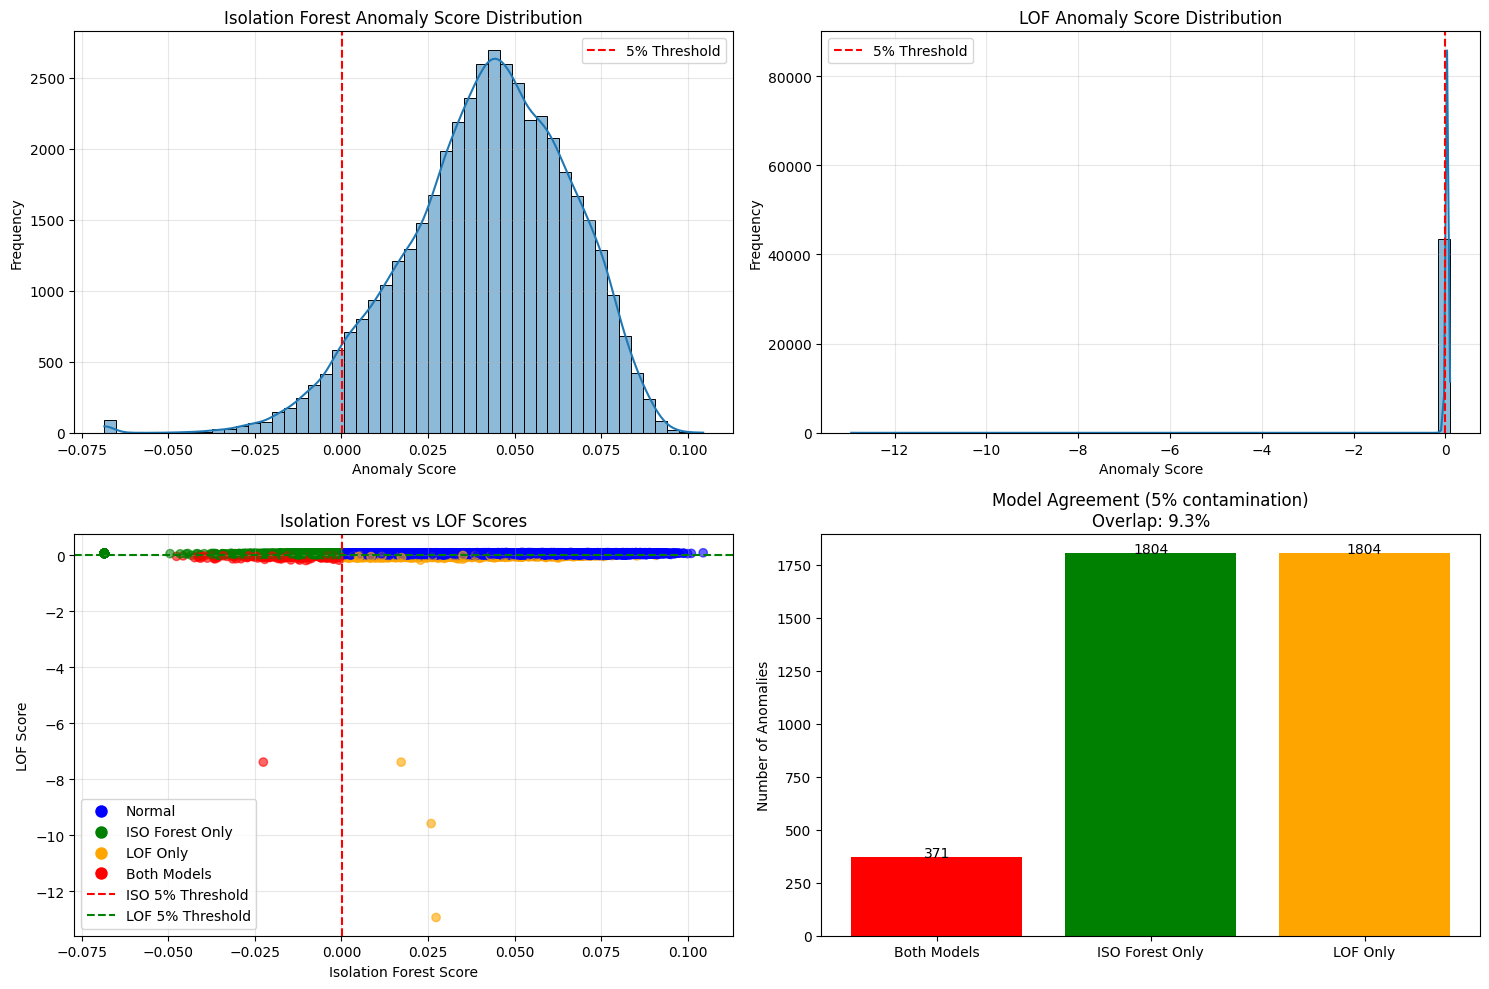

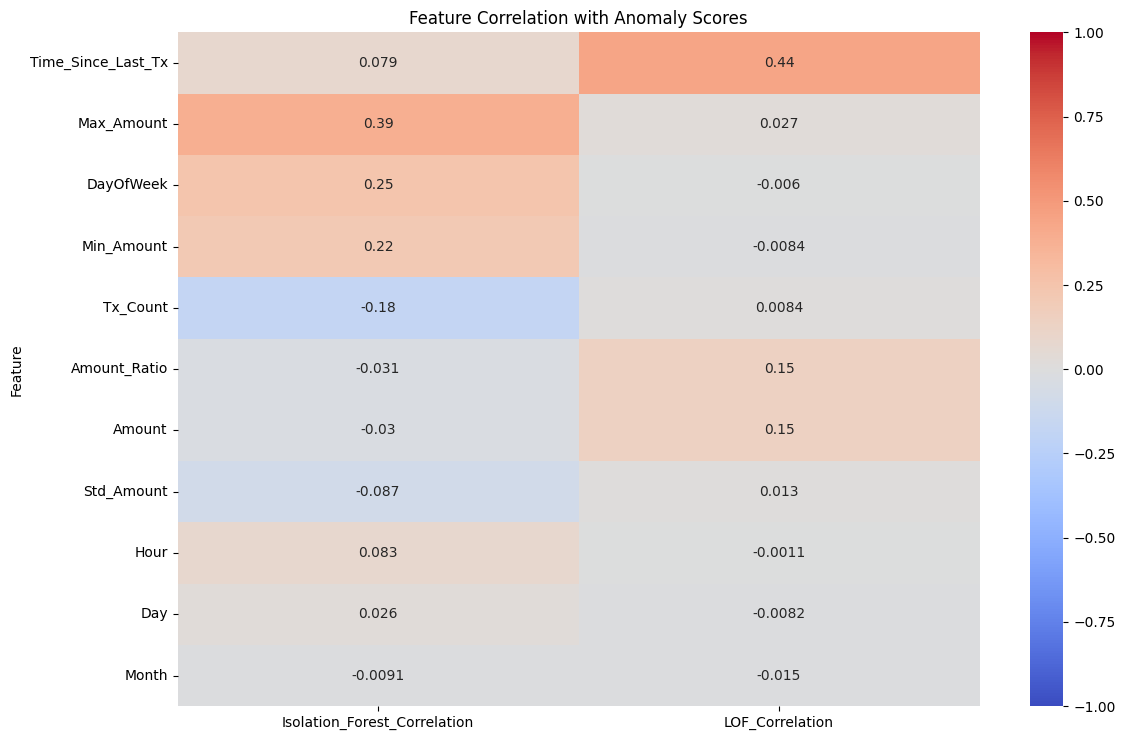

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

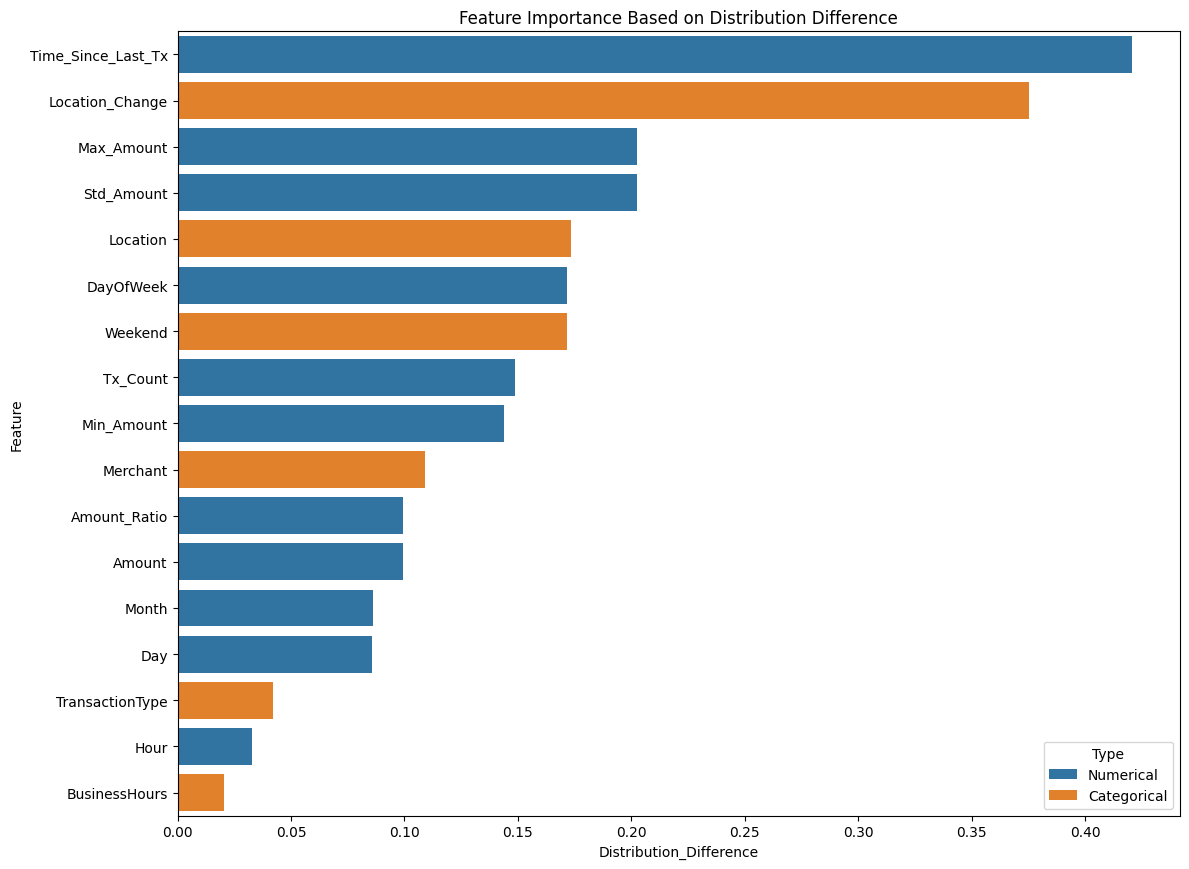

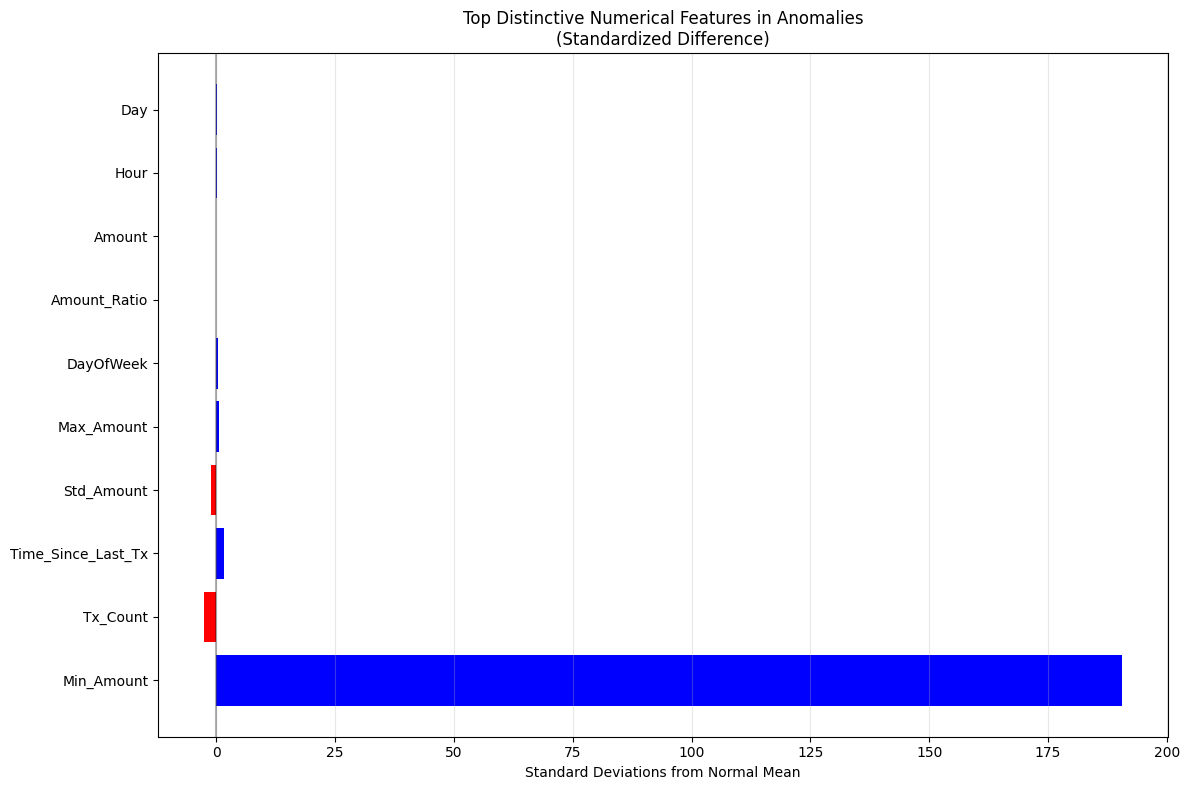

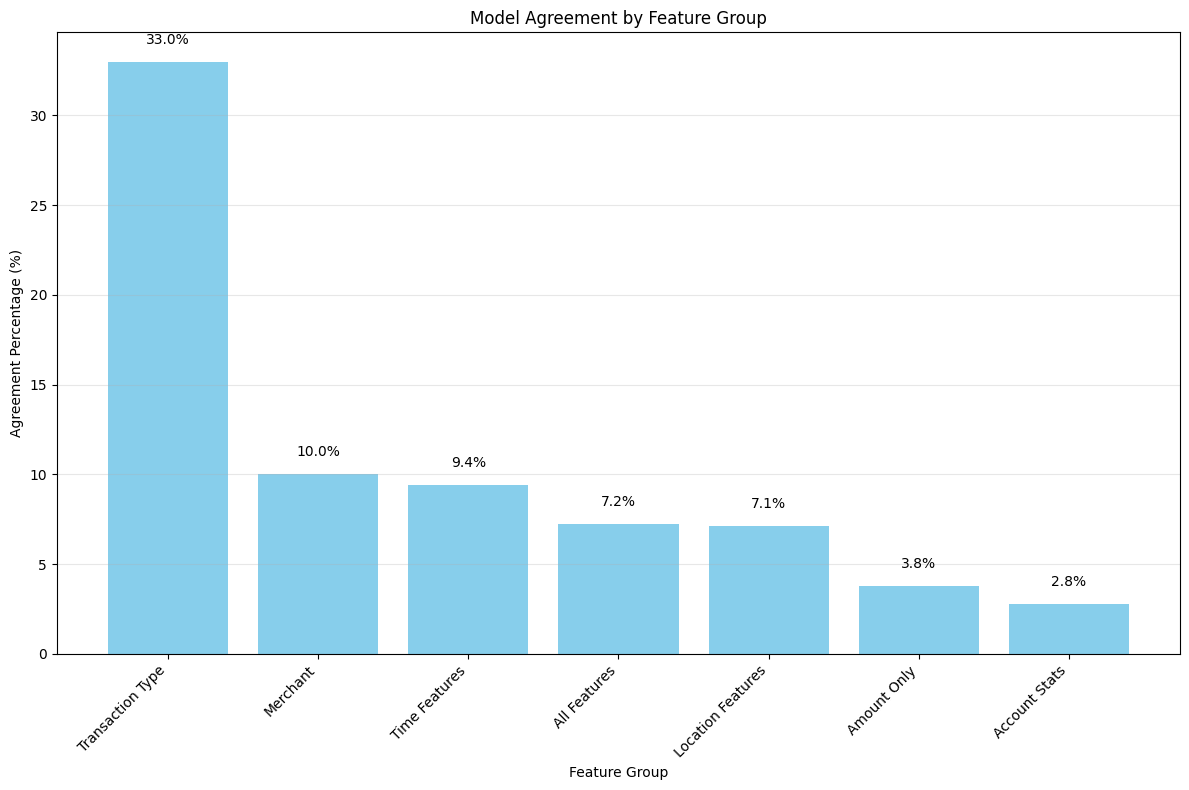

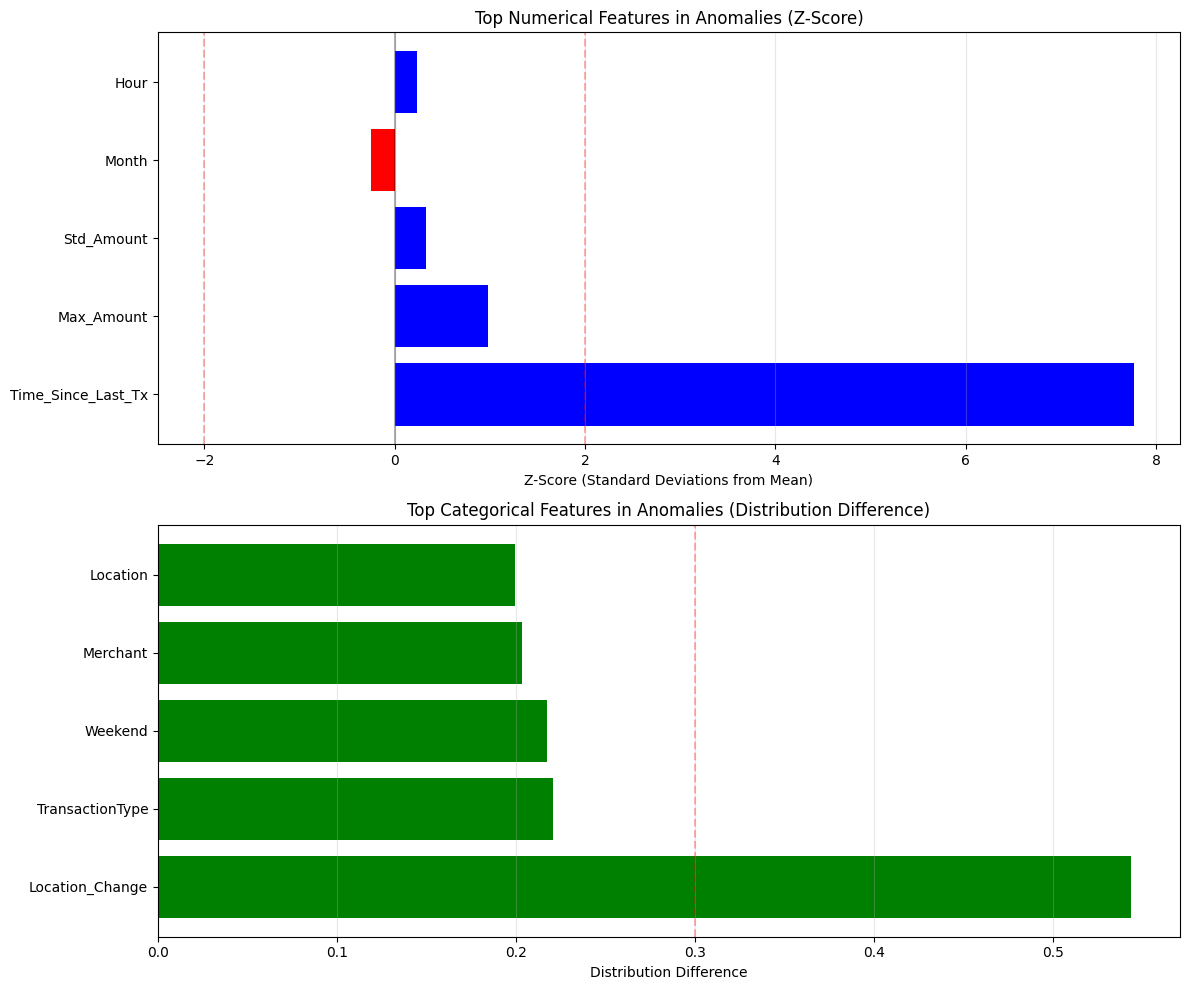

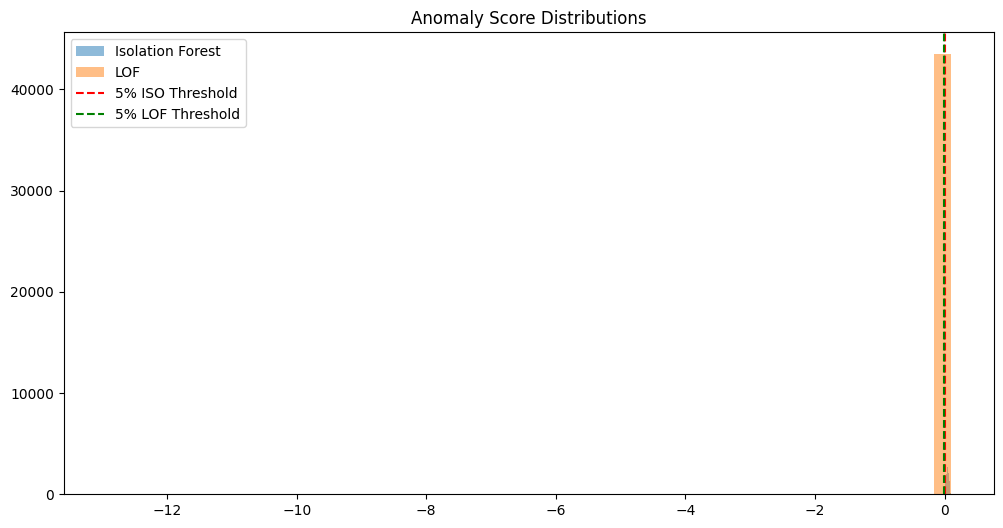

In [ ]:
def analyze_anomalies(test_results, output_folder='fraud_results'):
    """
    Basic anomaly analysis function to be compatible with original code
    """
    # Get anomalies from ensemble prediction
    return test_results[test_results['Ensemble_Prediction'] == -1].copy()

def visualize_results(test_results, anomaly_df, numerical_cols, output_folder='fraud_results'):
    """
    Basic visualization function to be compatible with original code
    """
    import os
    import matplotlib.pyplot as plt
    import numpy as np

    # Create output folder
    os.makedirs(output_folder, exist_ok=True)

    # Create a simple histogram of anomaly scores
    plt.figure(figsize=(12, 6))
    plt.hist(test_results['IsoForest_Score'], bins=50, alpha=0.5, label='Isolation Forest')
    plt.hist(test_results['LOF_Score'], bins=50, alpha=0.5, label='LOF')
    plt.axvline(x=np.percentile(test_results['IsoForest_Score'], 5), color='r', linestyle='--',
                label='5% ISO Threshold')
    plt.axvline(x=np.percentile(test_results['LOF_Score'], 5), color='g', linestyle='--',
                label='5% LOF Threshold')
    plt.title('Anomaly Score Distributions')
    plt.legend()
    plt.savefig(f"{output_folder}/score_distributions.png")

    return

def main(file_path='financial_anomaly_data.csv', feature_config=None):
    """
    Enhanced main function with additional analysis capabilities

    Parameters:
    -----------
    file_path : str
        Path to the input data file
    feature_config : dict, optional
        Configuration for feature selection. If None, use default features.
        Example: {
            'numerical_cols': ['Amount', 'Hour', 'Day'],
            'categorical_cols': ['TransactionType', 'Location']
        }
    """
    print("=== Enhanced Financial Transaction Fraud Detection Analysis ===")
    print("Using fixed 5% contamination rate for anomaly detection")


    # Load data
    df = load_data(file_path)
    if df is None:
        return

    # Preprocess data
    df_processed = preprocess_data(df)

    # Engineer features
    df_featured = engineer_features(df_processed)

    # Define feature columns for modeling based on config or defaults
    if feature_config is None:
        # Default numerical columns
        numerical_cols = ['Amount']
        # Add engineered numerical columns if they exist
        for col in ['Hour', 'Day', 'DayOfWeek', 'Month', 'Amount_Ratio', 'Time_Since_Last_Tx', 'Tx_Count',
                   'Std_Amount', 'Min_Amount', 'Max_Amount']:
            if col in df_featured.columns:
                numerical_cols.append(col)

        # Default categorical columns
        categorical_cols = []
        for col in ['TransactionType', 'Merchant', 'Location', 'Weekend', 'BusinessHours', 'Location_Change']:
            if col in df_featured.columns:
                categorical_cols.append(col)
    else:
        # Use features from config
        numerical_cols = [col for col in feature_config.get('numerical_cols', [])
                         if col in df_featured.columns]
        categorical_cols = [col for col in feature_config.get('categorical_cols', [])
                           if col in df_featured.columns]

    print(f"\nUsing {len(numerical_cols)} numerical features: {numerical_cols}")
    print(f"Using {len(categorical_cols)} categorical features: {categorical_cols}")

    # Split the data
    train_df, val_df, test_df = split_data(df_featured)

    # Prepare features
    preprocessor = prepare_features(train_df, categorical_cols, numerical_cols)

    # Build models with fixed 5% contamination rate
    print("\n--- Building models with fixed 5% contamination rate ---")
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import LocalOutlierFactor
    import numpy as np

    iso_forest = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=0.05,  # Fixed 5% contamination rate
        random_state=42
    )

    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=0.05,  # Fixed 5% contamination rate
        novelty=True
    )

    # Train the models
    print("\n--- Training and evaluating models ---")

    # Extract features, etc.
    X_train = preprocessor.fit_transform(train_df[numerical_cols + categorical_cols])
    X_val = preprocessor.transform(val_df[numerical_cols + categorical_cols])
    X_test = preprocessor.transform(test_df[numerical_cols + categorical_cols])

    # Train Isolation Forest
    print("Training Isolation Forest model with 5% contamination rate...")
    iso_forest.fit(X_train)

    # Train LOF
    print("Training Local Outlier Factor model with 5% contamination rate...")
    lof.fit(X_train)

    # Test on validation set (for potential analysis, but we'll stick with 5%)
    print("Scoring validation data...")
    val_results = val_df.copy()
    val_results['IsoForest_Score'] = iso_forest.decision_function(X_val)
    val_results['IsoForest_Prediction'] = iso_forest.predict(X_val)
    val_results['LOF_Score'] = lof.decision_function(X_val)
    val_results['LOF_Prediction'] = lof.predict(X_val)
    val_results['Ensemble_Prediction'] = np.where(
        (val_results['IsoForest_Prediction'] == -1) | (val_results['LOF_Prediction'] == -1),
        -1, 1
    )

    # Test on test set
    print("\n--- Testing models on test data ---")
    test_results = test_df.copy()
    test_results['IsoForest_Score'] = iso_forest.decision_function(X_test)
    test_results['IsoForest_Prediction'] = iso_forest.predict(X_test)
    test_results['LOF_Score'] = lof.decision_function(X_test)
    test_results['LOF_Prediction'] = lof.predict(X_test)
    test_results['Ensemble_Prediction'] = np.where(
        (test_results['IsoForest_Prediction'] == -1) | (test_results['LOF_Prediction'] == -1),
        -1, 1
    )

    print("\nTest results summary (using built-in 5% contamination):")
    print(f"Isolation Forest anomalies: {(test_results['IsoForest_Prediction'] == -1).sum()} ({(test_results['IsoForest_Prediction'] == -1).sum() / len(test_results) * 100:.2f}%)")
    print(f"LOF anomalies: {(test_results['LOF_Prediction'] == -1).sum()} ({(test_results['LOF_Prediction'] == -1).sum() / len(test_results) * 100:.2f}%)")
    print(f"Ensemble anomalies: {(test_results['Ensemble_Prediction'] == -1).sum()} ({(test_results['Ensemble_Prediction'] == -1).sum() / len(test_results) * 100:.2f}%)")

    # Define output folder
    output_folder = 'fraud_results'

    # Use our fixed function for anomaly score distribution analysis
    try:
        score_stats = analyze_anomaly_score_distribution(test_results, output_folder)
    except Exception as e:
        print(f"Error analyzing anomaly score distribution: {e}")
        score_stats = None

    # Run our new analysis functions
    try:
        # Save fraudulent transactions to separate files
        fraud_counts = save_fraud_transactions(test_results, output_folder)

        # Analyze feature importance
        feature_importance = analyze_feature_importance(test_results, test_df, numerical_cols,
                                                       categorical_cols, output_folder)

        # Create anomaly profiles
        anomaly_profiles = analyze_anomaly_profiles(test_results, test_df, numerical_cols,
                                                   categorical_cols, output_folder)

        # Evaluate feature subsets
        feature_groups_results = evaluate_feature_subsets(train_df, val_df, numerical_cols,
                                                         categorical_cols, output_folder)

        # Analyze specific anomalies
        specific_anomalies = analyze_specific_anomalies(test_results, test_df, numerical_cols,
                                                       categorical_cols, output_folder)

        # Get feature recommendations
        feature_recommendations = recommend_features(feature_importance, feature_groups_results,
                                                   numerical_cols, categorical_cols)

    except Exception as e:
        print(f"Error running enhanced analysis: {e}")
        import traceback
        traceback.print_exc()

    # Create basic anomaly dataframe for compatibility
    anomaly_df = analyze_anomalies(test_results)

    # Basic visualization for compatibility
    visualize_results(test_results, anomaly_df, numerical_cols, output_folder)

    # Print summary
    print("\n=== Fraud Detection System Summary ===")
    print(f"Total transactions analyzed: {len(df)}")
    print(f"Fixed contamination rate: 5%")
    print(f"Anomalies detected (test set): {len(anomaly_df)} ({len(anomaly_df)/len(test_results)*100:.2f}%)")

    if 'fraud_counts' in locals():
        print(f"Isolation Forest anomalies: {fraud_counts['iso_forest']} ({fraud_counts['iso_forest']/len(test_results)*100:.2f}%)")
        print(f"LOF anomalies: {fraud_counts['lof']} ({fraud_counts['lof']/len(test_results)*100:.2f}%)")
        print(f"Ensemble anomalies: {fraud_counts['ensemble']} ({fraud_counts['ensemble']/len(test_results)*100:.2f}%)")

    if 'score_stats' in locals() and score_stats:
        print(f"Model agreement: {score_stats['agreement_percentage']:.2f}% of anomalies detected by both models")

    print("\nModel performance metrics are based on unsupervised learning without labeled data.")
    print(f"\nDetailed results saved to the '{output_folder}' folder.")

    return {
        'models': {
            'isolation_forest': iso_forest,
            'local_outlier_factor': lof
        },
        'results': {
            'validation': val_results,
            'test': test_results
        },
        'anomalies': anomaly_df,
        'analysis': {
            'feature_importance': feature_importance if 'feature_importance' in locals() else None,
            'anomaly_profiles': anomaly_profiles if 'anomaly_profiles' in locals() else None,
            'feature_groups': feature_groups_results if 'feature_groups_results' in locals() else None,
            'specific_anomalies': specific_anomalies if 'specific_anomalies' in locals() else None,
            'feature_recommendations': feature_recommendations if 'feature_recommendations' in locals() else None
        }
    }

# Add function to integrate with the original script
if __name__ == "__main__":
    # Import or use functions directly from the script
    try:
        # Run with enhanced analysis
        results = enhanced_main('financial_anomaly_data.csv')
    except Exception as e:
        print(f"Enhanced analysis failed: {e}")
        print("Falling back to basic analysis...")
        # Fall back to original main function
        results_main = main('financial_anomaly_data.csv')